Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/My Drive/cancer_data')  #change dir
!mkdir CNN_assignment  #create a directory named train/
!unzip -q CNN_assignment.zip -d CNN_assignment/  #unzip data in train/


In [5]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/cancer_data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/cancer_data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [36]:
batch_size = 32
img_height = 180
img_width = 180

Splitting 80% of the images for training, and 20% for validation.

In [37]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [38]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [39]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

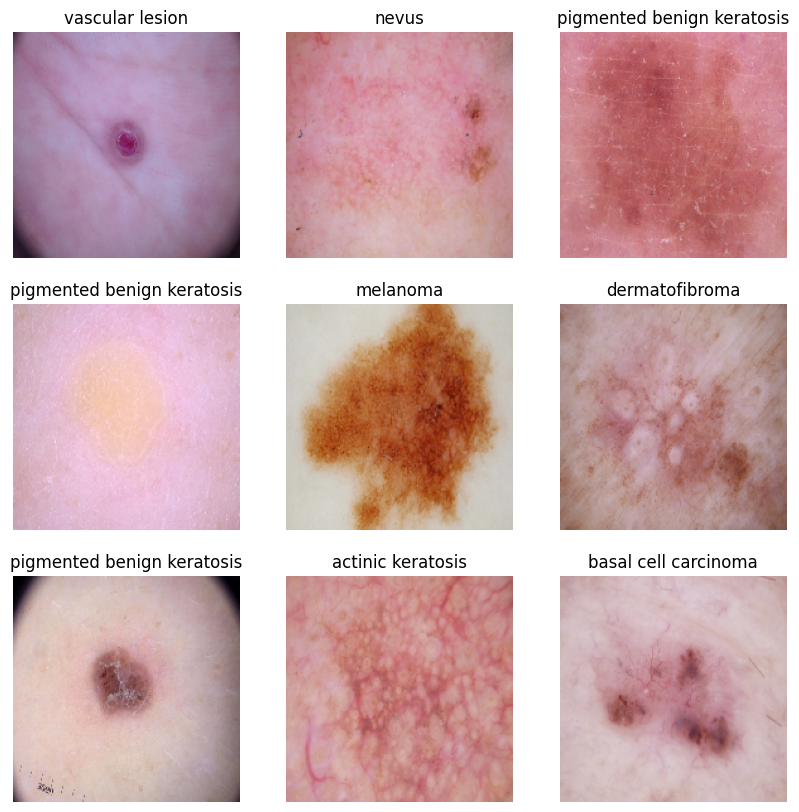

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [41]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model


In [42]:
# scaling and normalization is done between [0,1] from RGB value [0,255]

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# pixel values will be in [0,1]
print(np.min(first_image), np.max(first_image))

0.27973858 0.86666745


In [43]:
# creating a basic model
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [44]:
### Using adam optimizer for compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

### Train the model

In [46]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 116ms/step - loss: 1.9551 - accuracy: 0.2907 - val_loss: 1.7050 - val_accuracy: 0.4183
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.5912 - accuracy: 0.4291 - val_loss: 1.5317 - val_accuracy: 0.4944
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4507 - accuracy: 0.4972 - val_loss: 1.4004 - val_accuracy: 0.5190
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3397 - accuracy: 0.5223 - val_loss: 1.4312 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2198 - accuracy: 0.5664 - val_loss: 1.4297 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.1791 - accuracy: 0.5725 - val_loss: 1.3512 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.0938 - accuracy: 0.6044 - val_loss: 1.3718 - val_accuracy: 0.5369
Epoch 8/20
5

### Visualizing training results

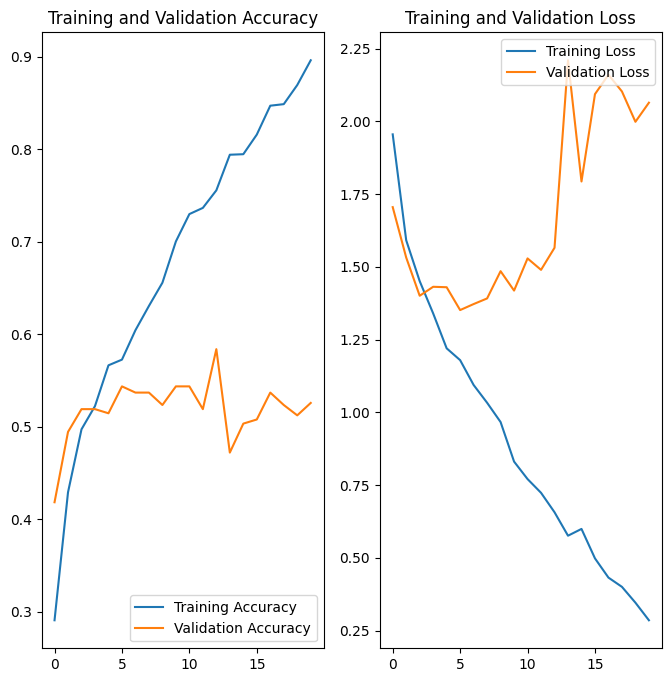

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training accuracy is off with validation accuracy. Model has achieved only 55% accuracy

### Model looks to be overfitted as training accuracy didn't go well with validation accuracy, the gap is very evident. There could be the reason that because of less dataset model is learning from the noises.

### We need to apply augmentation strategy to increase the dataset

In [49]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

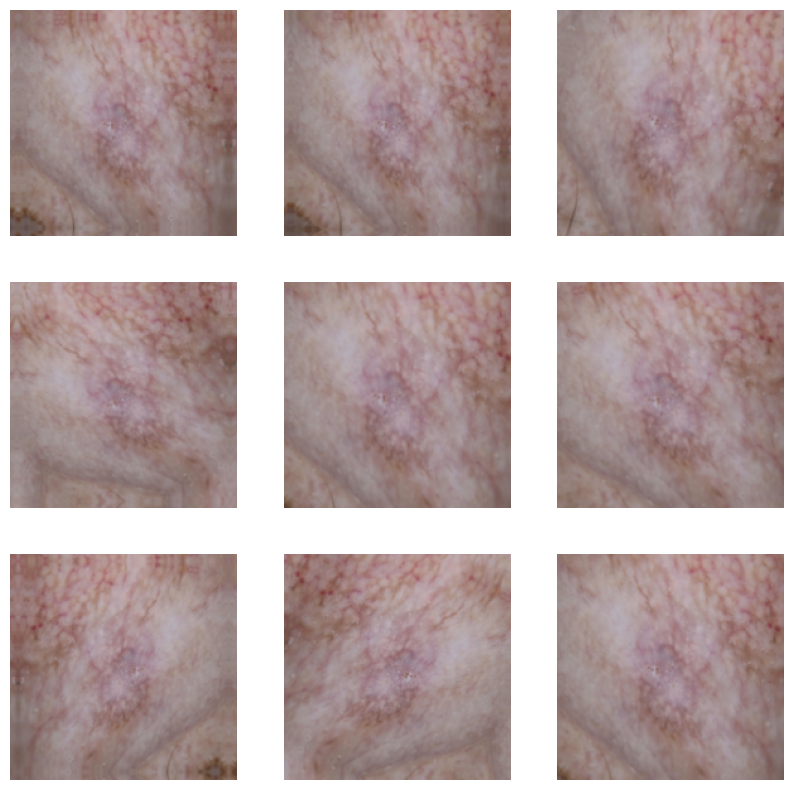

In [50]:
# Visualize a few augmented examples by applying data augmentation to the same image several times-

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [67]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

### Compiling the model

In [68]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [69]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_12 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_14 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 90, 90, 32)      

### Training the model

In [70]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 6s 49ms/step - loss: 2.6527 - accuracy: 0.3438 - val_loss: 3.1066 - val_accuracy: 0.1723
Epoch 2/25
56/56 [==============================] - 3s 46ms/step - loss: 1.5655 - accuracy: 0.4626 - val_loss: 4.8232 - val_accuracy: 0.0940
Epoch 3/25
56/56 [==============================] - 3s 45ms/step - loss: 1.4183 - accuracy: 0.5011 - val_loss: 6.5227 - val_accuracy: 0.1409
Epoch 4/25
56/56 [==============================] - 2s 45ms/step - loss: 1.3417 - accuracy: 0.5346 - val_loss: 5.7538 - val_accuracy: 0.1812
Epoch 5/25
56/56 [==============================] - 2s 45ms/step - loss: 1.2864 - accuracy: 0.5497 - val_loss: 5.3256 - val_accuracy: 0.1790
Epoch 6/25
56/56 [==============================] - 3s 49ms/step - loss: 1.2935 - accuracy: 0.5441 - val_loss: 5.8217 - val_accuracy: 0.2282
Epoch 7/25
56/56 [==============================] - 3s 45ms/step - loss: 1.2144 - accuracy: 0.5675 - val_loss: 3.9497 - val_accuracy: 0.3647
Epoch 8/25
56

### Visualizing the results

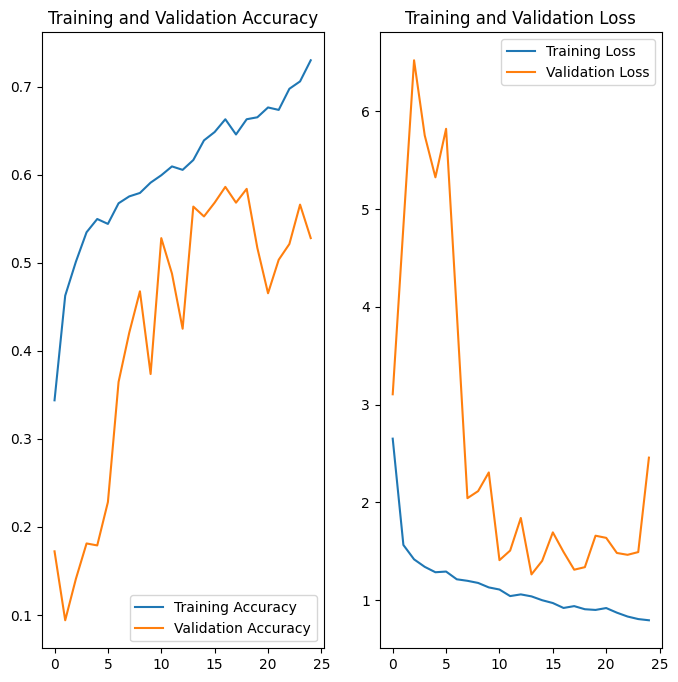

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### There is improvement from previous result as now model doesn't looks to be overfitted as the gap in traning and validation accuracy is not much but still the accuracy percentage is not good.

In [89]:
# Check the count of images in every class and see if dataset is imbalance
import os
Categories = os.listdir(data_dir_train)

for dir in Categories:
  path = str(data_dir_train) + "/" + dir
  print('Category : '+ dir)
  print(len(os.listdir(path)))
  print('==========')


Category : actinic keratosis
114
Category : basal cell carcinoma
376
Category : dermatofibroma
95
Category : melanoma
438
Category : nevus
357
Category : pigmented benign keratosis
462
Category : seborrheic keratosis
77
Category : squamous cell carcinoma
181
Category : vascular lesion
139


### The data is not even in all the categories


In [85]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [90]:
import Augmentor

for dir in Categories:
  path = str(data_dir_train) + "/" + dir
  p = Augmentor.Pipeline(path)
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/cancer_data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E005183E980>: 100%|██████████| 500/500 [00:18<00:00, 27.31 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/cancer_data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E005181BDC0>: 100%|██████████| 500/500 [00:17<00:00, 28.37 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/cancer_data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E0051803790>: 100%|██████████| 500/500 [00:19<00:00, 25.25 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/cancer_data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x7E005C5F6740>: 100%|██████████| 500/500 [01:13<00:00,  6.77 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/cancer_data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3008x2000 at 0x7E0051855F60>: 100%|██████████| 500/500 [01:19<00:00,  6.26 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/cancer_data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E0051FE58A0>: 100%|██████████| 500/500 [00:17<00:00, 28.44 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/cancer_data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E0051854BE0>: 100%|██████████| 500/500 [00:39<00:00, 12.71 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/cancer_data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E0051A041F0>: 100%|██████████| 500/500 [00:17<00:00, 28.17 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/cancer_data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E0051BEAD70>: 100%|██████████| 500/500 [00:20<00:00, 24.39 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [91]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [99]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [100]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [101]:
# scaling and normalization is done between [0,1] from RGB value [0,255]

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# pixel values will be in [0,1]
print(np.min(first_image), np.max(first_image))

0.25669852 1.0


In [112]:
model = Sequential([
  layers.Rescaling(1./255),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [113]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [114]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
169/169 [==============================] - 41s 219ms/step - loss: 2.0359 - accuracy: 0.4084 - val_loss: 25.1949 - val_accuracy: 0.1084
Epoch 2/10
169/169 [==============================] - 43s 249ms/step - loss: 1.2333 - accuracy: 0.5456 - val_loss: 13.9906 - val_accuracy: 0.1522
Epoch 3/10
169/169 [==============================] - 40s 234ms/step - loss: 1.0481 - accuracy: 0.6142 - val_loss: 4.5679 - val_accuracy: 0.2554
Epoch 4/10
169/169 [==============================] - 41s 234ms/step - loss: 0.8546 - accuracy: 0.6777 - val_loss: 1.7553 - val_accuracy: 0.4892
Epoch 5/10
169/169 [==============================] - 40s 232ms/step - loss: 0.6830 - accuracy: 0.7435 - val_loss: 1.5665 - val_accuracy: 0.5397
Epoch 6/10
169/169 [==============================] - 40s 233ms/step - loss: 0.5318 - accuracy: 0.7986 - val_loss: 0.9361 - val_accuracy: 0.6956
Epoch 7/10
169/169 [==============================] - 41s 234ms/step - loss: 0.5105 - accuracy: 0.8095 - val_loss: 0.8949 - val_

 We see that the validation accuracy is going down after 10-12 epocs making model with 10 epocs

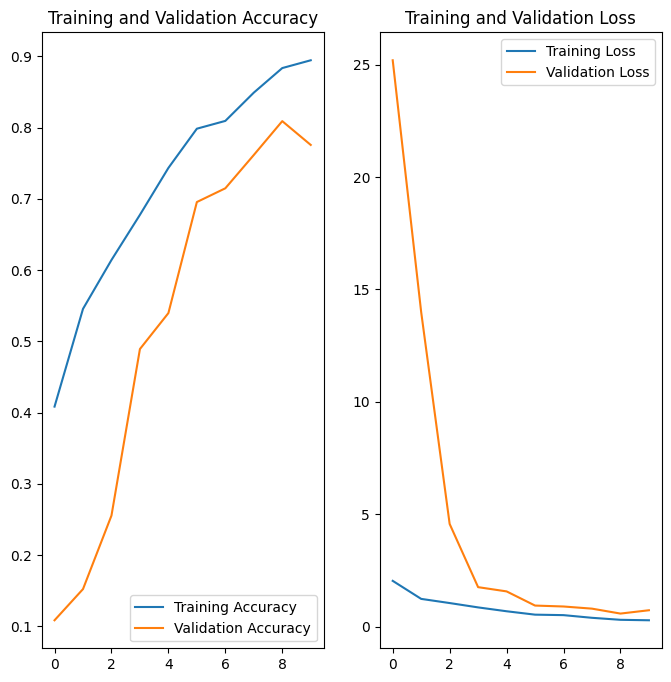

In [115]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Result is good with accuracy and validation. class balancing with augmenation really helps a lot.

---

